In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from math import sqrt

sam = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/samsung.csv") #작업 경로에 csv파일을 지정해줘야 함. yahoo financial에서 5개년치 삼성전자 주식.
sam = sam.sort_index(ascending=False)
sam=sam.reset_index() #columns 순서 맞추기 위함.
sam=sam.drop(["index"], axis=1)

In [ ]:
def calMACD(df, short=12, long=26, signal = 9):
  df['MACD'] = df['Close'].ewm(span = short, min_periods = short-1, adjust = False).mean() - df['Close'].ewm(span = long, min_periods = long-1, adjust=False).mean()
  df['MACD_Signal'] = df['MACD'].ewm(span = signal, min_periods = signal-1, adjust=False).mean()
  df['MACD_OSC'] = df['MACD'] - df['MACD_Signal']
  return df

print(calMACD(sam))

            Date     Open     High      Low    Close     Adj Close    Volume  \
0     2022-06-30  57200.0  57600.0  57000.0  57000.0  57000.000000  18499814   
1     2022-06-29  58500.0  58800.0  58000.0  58000.0  58000.000000  14677138   
2     2022-06-28  59200.0  59500.0  58700.0  59400.0  59400.000000  13540538   
3     2022-06-27  59000.0  59900.0  58300.0  58800.0  58800.000000  18122236   
4     2022-06-24  57900.0  59100.0  57700.0  58400.0  58400.000000  23256103   
...          ...      ...      ...      ...      ...           ...       ...   
1220  2017-07-06  48000.0  48100.0  47720.0  48060.0  41753.902344  10923050   
1221  2017-07-05  46820.0  47680.0  46780.0  47580.0  41336.882813  10640250   
1222  2017-07-04  47160.0  47400.0  46900.0  47000.0  40832.988281   7961000   
1223  2017-07-03  47500.0  47780.0  47120.0  47220.0  41024.121094   6805550   
1224  2017-06-30  47500.0  47620.0  47100.0  47540.0  41302.132813  11877550   

            MACD  MACD_Signal    MACD_O

# 새 섹션

In [ ]:
scaler = MinMaxScaler()
sam["Close"]=scaler.fit_transform(sam["Close"].values.reshape(-1,1)) #데이터가 scaling을 위함. 0~1까지의 값을 가질 수 있도록.
data=sam["Close"]

In [ ]:
def make_dataset(data, window_size = 10): #sequence는 10으로, input size는 1로 설정함.
    feature_list =[]
    label_list =[]
    for i in range(len(data)-window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(data.iloc[i+window_size]))

    return np.array(feature_list), np.array(label_list)


data_X, data_Y = make_dataset(data)

train_data, train_label = data_X[:-100], data_Y[:-100]
test_data, test_label = data_X[-100:], data_Y[-100:]


In [ ]:
train_data = torch.FloatTensor(train_data) #학습할 수 있는 형태로 변환
train_label = torch.FloatTensor(train_label) #학습할 수 있는 형태로 변환
train_data=train_data.view(train_data.shape[0],10,-1)
train_label=train_label.view(train_data.shape[0],1)

train_rnn = torch.utils.data.TensorDataset(train_data, train_label)
train_loader =torch.utils.data.DataLoader(dataset = train_rnn, batch_size =train_data.shape[0], shuffle = False)

## Test
test_data = torch.FloatTensor(test_data)
test_label = torch.FloatTensor(test_label)
test_data=test_data.view(test_data.shape[0],10,-1)

test_rnn = torch.utils.data.TensorDataset(test_data, test_label)
test_loader =torch.utils.data.DataLoader(dataset = test_rnn, batch_size =train_data.shape[0], shuffle = False)

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers=layers, batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias = True)

    def forward(self,x):
        x, _status = self.rnn(x)
        x = self.fc(x[:,-1])
        return x

model = RNN(input_dim=1,hidden_dim=30,output_dim=1,layers=2)
loss_fn = nn.MSELoss(reduction ="mean")
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) #Optimizer로 Adam을 사용함

for epoch in range(500): #epoch의 수
    for i,(train_, label_) in enumerate(train_loader):
        # print(train_)
        # print(label_)
        optimizer.zero_grad()
        y_pred = model(train_)
        loss = loss_fn(label_, y_pred) #loss_fn : 손실(loss)을 갖는 텐서를 반환하는 손실 함수
        loss.backward()
        optimizer.step()
    if epoch% 50 ==0:
        print(epoch ,loss.item())

0 0.09080129861831665
50 0.0006167630781419575
100 0.0004139091179240495
150 0.0003754998615477234
200 0.000353244919097051
250 0.0003382805152796209
300 0.0003280137898400426
350 0.0004550564044620842
400 0.0003266666899435222
450 0.0003197748155798763


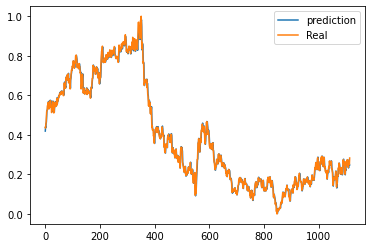

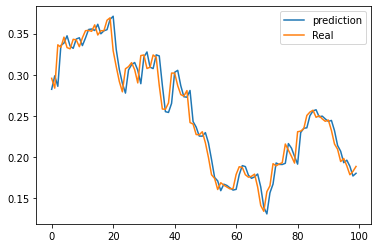

In [ ]:
# scaled된 데이터로 학습 및 예측

#학습
plt.plot(y_pred.detach().numpy(), label ="prediction")
plt.plot(train_label, label="Real")
plt.legend()
plt.show()

#테스트
y_test_pred = model(test_data)
plt.plot(y_test_pred.detach().numpy(), label ="prediction")
plt.plot(test_label, label="Real")
plt.legend()
plt.show()



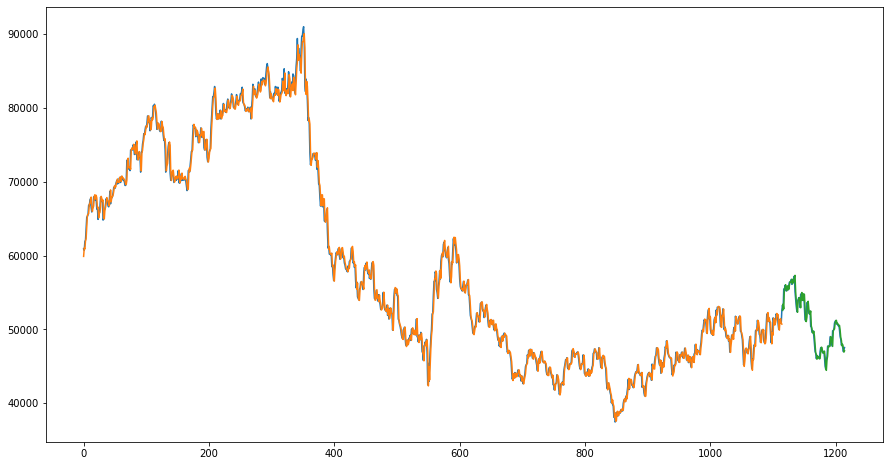

In [ ]:
y_train_pred = model(train_data)
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy()) # 실제 훈련 데이터의 형태로 변형하기 위해 이미 스케일된 값을 자연수 형태로 변경

y_test_pred = model(test_data)
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy()) # 실제 훈련 데이터의 형태로 변형하기 위해 이미 스케일된 값을 자연수 형태로 변경

trainPredictPlot = np.empty_like(sam.iloc[10:]["Close"])
trainPredictPlot[:]=np.nan
trainPredictPlot[0:len(y_train_pred)] = y_train_pred[:,0] #학습 값

testPredictPlot = np.empty_like(sam.iloc[10:]["Close"])
testPredictPlot[:] = np.nan
testPredictPlot[len(y_train_pred):len(sam.iloc[10:]["Close"])+1] = y_test_pred[:,0] # train된 데이터를 기반으로 다음 예측 값을 넣음


plt.figure(figsize=(15,8))
plt.plot(scaler.inverse_transform(sam.iloc[10:]["Close"].values.reshape(-1,1)), label='shape') #실제 데이터
plt.plot(trainPredictPlot, label='train') # 학습 부분
plt.plot(testPredictPlot, label='test') # 예측 부분
plt.show()



In [ ]:

# def calMACD(df, short=12, long=26, signal = 9):
#   df['MACD'] = df['Close'].ewm(span = long, min_periods = long-1, adjust = False).mean() - df['Close'].ewm(span = long, min_periods = long-1, adjust=False).mean()
#   df['MACD_Signal'] = df['MACD'].ewm(span = signal, min_periods = signal-1, adjust=False).mean()
#   df['MACD_OSC'] = df['MACD'] - df['MACD_Signal']
#   return df

# print(calMACD(data))